In [1]:
import os
import mne
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict
print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
path_table = pd.read_json('path_table.json')
path_table

,em_noise_path,processed_path,raw_path,raw_resting_path
MEG_S01_R04,rawdata/20190326_MEG_Noise/Noise-default_Noise...,processed_data/MEG_S01_R04,rawdata/20190326_RSVP_MEG_S01/S01_lixiangTHU_2...,rawdata/20190326_RSVP_MEG_S01/S01-resting_lixi...
MEG_S01_R05,rawdata/20190326_MEG_Noise/Noise-default_Noise...,processed_data/MEG_S01_R05,rawdata/20190326_RSVP_MEG_S01/S01_lixiangTHU_2...,rawdata/20190326_RSVP_MEG_S01/S01-resting_lixi...
MEG_S01_R06,rawdata/20190326_MEG_Noise/Noise-default_Noise...,processed_data/MEG_S01_R06,rawdata/20190326_RSVP_MEG_S01/S01_lixiangTHU_2...,rawdata/20190326_RSVP_MEG_S01/S01-resting_lixi...
MEG_S01_R07,rawdata/20190326_MEG_Noise/Noise-default_Noise...,processed_data/MEG_S01_R07,rawdata/20190326_RSVP_MEG_S01/S01_lixiangTHU_2...,rawdata/20190326_RSVP_MEG_S01/S01-resting_lixi...
MEG_S01_R08,rawdata/20190326_MEG_Noise/Noise-default_Noise...,processed_data/MEG_S01_R08,rawdata/20190326_RSVP_MEG_S01/S01_lixiangTHU_2...,rawdata/20190326_RSVP_MEG_S01/S01-resting_lixi...
...,...,...,...,...
EEG_S09_R07,--,processed_data/EEG_S09_R07,rawdata/20200104_RSVP_EEG_S09/7.cnt,--
EEG_S09_R08,--,processed_data/EEG_S09_R08,rawdata/20200104_RSVP_EEG_S09/8.cnt,--
EEG_S09_R09,--,processed_data/EEG_S09_R09,rawdata/20200104_RSVP_EEG_S09/9.cnt,--
EEG_S09_R10,--,processed_data/EEG_S09_R10,rawdata/20200104_RSVP_EEG_S09/10.cnt,--


In [3]:
iter_freqs = [
    ('Delta', 0, 4),
    ('Theta', 4, 7),
#     ('Alpha', 8, 12),
#     ('Beta', 13, 25),
#     ('Gamma', 30, 45)
]

tmin, tmax = -0.2, 1.2
picks = 'mag'

In [4]:
n_jobs = 48
_svm = svm.SVC(gamma='scale', kernel='rbf', class_weight='balanced')
clf = make_pipeline(StandardScaler(), _svm)
all_decoder = make_pipeline(mne.decoding.Vectorizer(), clf)
time_decoder = mne.decoding.SlidingEstimator(clf, n_jobs=n_jobs, scoring='f1')
skf = StratifiedKFold(n_splits=10)
xdawn = mne.preprocessing.Xdawn(n_components=6, reg='diagonal_fixed')

def perform_MVPA(epochs, all_decoder=all_decoder, time_decoder=time_decoder, CV=skf, xdawn=False):
    # MVPA method for epochs
    # all_decoder: classification pipeline,
    #              when fit, receive 3-dim dataset and label,
    #              when predict, receive 3-dim dataset, return predicted label
    # time_decoder: a time-resolution version of all_decoder
    # CV: cross-validation generator
    # xdawn: xdawn denoise model, xdawn is invalid when xdawn is False
    
    # Get X, y
    X = epochs.get_data()
    y = events[:, -1]
    print(X.shape, y.shape)
    
    # Prepare predicts
    y_predict = np.zeros(X.shape[0])
    y_time_predict = np.zeros((X.shape[0], X.shape[2]))
    print(y_predict.shape, y_time_predict.shape)
    
    # Cross validation
    # Split train and test
    for train, test in CV.split(X, y):
        # Make train and test data
        if xdawn:
            epochs.baseline = None
            # Fit xdawn
            xdawn.fit(epochs[train])
            # Transoform using xdawn
            X_train, y_train = xdawn.apply(epochs[train])['1'].get_data(), y[train]
            X_test, y_test = xdawn.apply(epochs[test])['1'].get_data(), y[test]
        else:
            # Seperate train and test
            X_train, y_train = X[train], y[train]
            X_test, y_test = X[test], y[test]

        # All time train and test
        all_decoder.fit(X_train, y_train)
        y_predict[test] = all_decoder.predict(X_test)
        # Window time train and test
        time_decoder.fit(X_train, y_train)
        y_time_predict[test, :] = time_decoder.predict(X_test)
    
    # Return
    return dict(
        y_true = y,
        y_predict = y_predict,
        y_time_predict = y_time_predict,
        times = epochs.times,
    )

def report_MVPA(predicts):
    y_true = predicts['y_true']
    y_pred = predicts['y_predict']
    y_time_pred = predicts['y_time_predict']
    # All time report
    print(sklearn.metrics.classification_report(y_pred=y_pred, y_true=y_true))
    print(sklearn.metrics.precision_score(y_pred=y_pred, y_true=y_true, average='weighted'))
    # Window time report
    scores = np.zeros(y_time_pred.shape[1])
    for j, y_pred in enumerate(y_time_pred.transpose()):
        scores[j] = sklearn.metrics.precision_score(y_pred=y_pred, y_true=y_true, average='weighted')
    plt.plot(scores)

Opening raw data file processed_data/MEG_S01_R04/ica_denoised-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade : 3
Opening raw data file processed_data/MEG_S01_R05/ica_denoised-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade : 3
Opening raw data file processed_data/MEG_S01_R06/ica_denoised-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade : 3
Opening raw data file processed_data/MEG_S01_R07/ica_denoised-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade : 3
Opening raw data file processed_data/MEG_S01_R08/ica_denoised-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade

Index: 2458083: 100%|██████████| 392/392 [00:11<00:00, 33.81it/s]


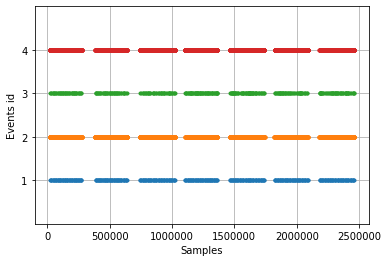

--------------------------------------------------------------------------------
('Delta', 0, 4)
10165 matching events found
Applying baseline correction (mode: mean)
Removing 5 compensators from info because not all compensation channels were picked.
Not setting metadata
0 projection items activated
Loading data for 2713 events and 1681 original time points ...


<ipython-input-5-282fc4facf82>:26: RuntimeWarning: The measurement information indicates a low-pass frequency of 600 Hz. The decim=10 parameter will result in a sampling frequency of 120 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(rawraw.copy(), events, picks=picks, tmin=tmin, tmax=tmax, decim=10)


0 bad epochs dropped
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 199 samples (1.658 sec)



<ipython-input-5-282fc4facf82>:31: RuntimeWarning: filter_length (199) is longer than the signal (169), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq=l_freq, h_freq=h_freq, n_jobs=n_jobs)
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=48)]: Done 155 tasks      | elapsed:    2.0s
[Parallel(n_jobs=48)]: Done 768 tasks      | elapsed:    2.2s
[Parallel(n_jobs=48)]: Done 7296 tasks      | elapsed:    3.1s
[Parallel(n_jobs=48)]: Done 19968 tasks      | elapsed:    4.5s
[Parallel(n_jobs=48)]: Done 34944 tasks      | elapsed:    6.2s
[Parallel(n_jobs=48)]: Done 52224 tasks      | elapsed:    8.1s
[Parallel(n_jobs=48)]: Done 71808 tasks      | elapsed:   10.3s
[Parallel(n_jobs=48)]: Done 93696 tasks      | elapsed:   12.9s
[Parallel(n_jobs=48)]: Done 117888 tasks      | elapsed:   15.7s
[Parallel(n_jobs=48)]: Done 144384 tasks      | elapse

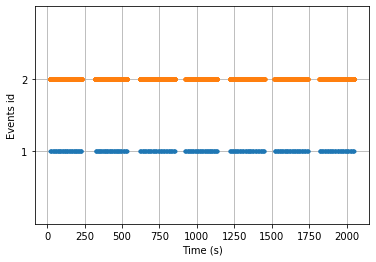

{'1': 1, '2': 2}
1


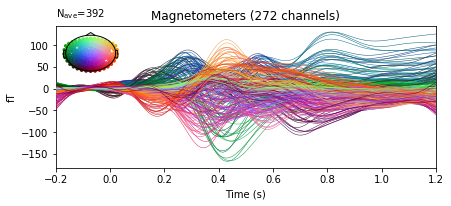

2


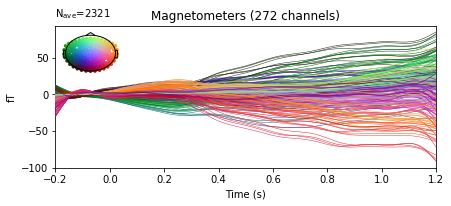

(2713, 272, 169) (2713,)
(2713,) (2713, 169)
[                                                          ]   0.00% Fitting SlidingEstimator |
[                                                          ]   0.00% Transforming SlidingEstimato
[                                                          ]   0.00% Fitting SlidingEstimator |
[                                                          ]   0.00% Transforming SlidingEstimato
[                                                          ]   0.00% Fitting SlidingEstimator |
[                                                          ]   0.00% Transforming SlidingEstimato
[                                                          ]   0.00% Fitting SlidingEstimator |
[                                                          ]   0.00% Transforming SlidingEstimato
[                                                          ]   0.00% Fitting SlidingEstimator |
[                                                          ]   0.00% Transforming S

<ipython-input-5-282fc4facf82>:26: RuntimeWarning: The measurement information indicates a low-pass frequency of 600 Hz. The decim=10 parameter will result in a sampling frequency of 120 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(rawraw.copy(), events, picks=picks, tmin=tmin, tmax=tmax, decim=10)


0 bad epochs dropped
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 199 samples (1.658 sec)



<ipython-input-5-282fc4facf82>:31: RuntimeWarning: filter_length (199) is longer than the signal (169), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq=l_freq, h_freq=h_freq, n_jobs=n_jobs)
[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=48)]: Done 139 tasks      | elapsed:    3.3s
[Parallel(n_jobs=48)]: Done 784 tasks      | elapsed:    3.5s
[Parallel(n_jobs=48)]: Done 7296 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done 19968 tasks      | elapsed:    5.9s
[Parallel(n_jobs=48)]: Done 34944 tasks      | elapsed:    7.5s
[Parallel(n_jobs=48)]: Done 52224 tasks      | elapsed:    9.5s
[Parallel(n_jobs=48)]: Done 71808 tasks      | elapsed:   11.6s
[Parallel(n_jobs=48)]: Done 93696 tasks      | elapsed:   13.7s
[Parallel(n_jobs=48)]: Done 117888 tasks      | elapsed:   16.4s
[Parallel(n_jobs=48)]: Done 144384 tasks      | elapse

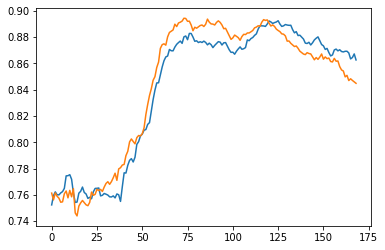

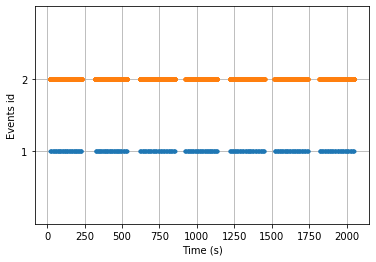

{'1': 1, '2': 2}
1


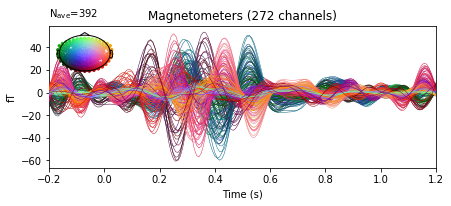

2


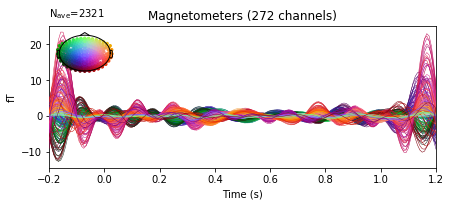

(2713, 272, 169) (2713,)
(2713,) (2713, 169)
[                                                          ]   0.00% Fitting SlidingEstimator |
[                                                          ]   0.00% Transforming SlidingEstimato
[                                                          ]   0.00% Fitting SlidingEstimator |
[                                                          ]   0.00% Transforming SlidingEstimato
[                                                          ]   0.00% Fitting SlidingEstimator |
[                                                          ]   0.00% Transforming SlidingEstimato
[                                                          ]   0.00% Fitting SlidingEstimator |
[                                                          ]   0.00% Transforming SlidingEstimato
[                                                          ]   0.00% Fitting SlidingEstimator |
[                                                          ]   0.00% Transforming S

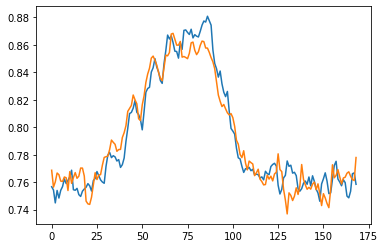

In [5]:
regexp = 'MEG_S01'
MVPA_results = defaultdict(list)

# Read and concatenate raw data
fnames = [os.path.join(e, 'ica_denoised-raw.fif') for e in path_table.loc[[e for e in path_table.index if regexp in e]]['processed_path']]
rawraw = mne.concatenate_raws([mne.io.read_raw_fif(e) for e in fnames])

# Filter events
events = mne.find_events(rawraw, stim_channel='UPPT001')
sfreq = rawraw.info['sfreq']
with tqdm.tqdm(events[events[:, -1]==1]) as pbar:
    for e in pbar:
        pbar.set_description('Index: {}'.format(e[0]))
        for ee in events:
            if all([ee[-1] == 2, abs(ee[0]-e[0])<sfreq]):
                ee[-1] = 4
mne.viz.plot_events(events)

for freqs in iter_freqs:
    print('-' * 80)
    print(freqs)
    name_freq, l_freq, h_freq = freqs

    # Get epochs
    # Raw epochs
    epochs = mne.Epochs(rawraw.copy(), events, picks=picks, tmin=tmin, tmax=tmax, decim=10)
    # Clear events
    epochs = epochs[['1', '2']]
    epochs.load_data()
    # Filter epochs
    epochs.filter(l_freq=l_freq, h_freq=h_freq, n_jobs=n_jobs)

    event_id = epochs.event_id
    # Get and plot events
    events = epochs.events
    mne.viz.plot_events(events, sfreq=sfreq)
    print(event_id)
    # Plot epochs
    for event in event_id:
        print(event)
        epochs[event].average().plot(spatial_colors=True)

    # perform MVPA
    MVPA_predicts = perform_MVPA(epochs.copy())
    # Report MVPA
    report_MVPA(MVPA_predicts)
    MVPA_results[name_freq].append(('origin', MVPA_predicts))
    
    # perform xdawn MVPA
    xdawn_MVPA_predicts = perform_MVPA(epochs.copy(), xdawn=xdawn)
    # Report xdawn MVPA
    report_MVPA(xdawn_MVPA_predicts)
    MVPA_results[name_freq].append(('xdawn', xdawn_MVPA_predicts))
    


In [6]:
df = pd.DataFrame(MVPA_results)
df

,Delta,Theta
0,"(origin, {'y_true': [2, 2, 2, 2, 2, 2, 2, 2, 2...","(origin, {'y_true': [2, 2, 2, 2, 2, 2, 2, 2, 2..."
1,"(xdawn, {'y_true': [2, 2, 2, 2, 2, 2, 2, 2, 2,...","(xdawn, {'y_true': [2, 2, 2, 2, 2, 2, 2, 2, 2,..."


In [7]:
df.to_json('MVPA_predicts_{}.json'.format(regexp))